# Алгоритм Беллмана-Форда

Робота виконана студентами ШІ29: Васюком Миколою та Когутаничем Романом.


Мета: Застосувати алгоритм Беллмана-Форда для знаходження найкоротших шляхів в графі, порівняти ефективність алгоритму в залежності від кількості вершин та ребер в графі.

## 1. Імпортуємо необхідні бібліотеки:
time - для виміру часу\
pandas - для обробки та аналізу даних\
seaborn - для створення графіків\
matplotlib - для візуалізації даних\
networkx - для створення та візуалізації графів\
numpy - для роботи з масивами та математичними операціями

In [28]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

sns.set_theme(style="whitegrid")

## 2. Створення класу граф

In [79]:
import random

class Graph:
    # Ініціалізація графу
    def __init__(self, vertices):
        self.V = vertices
        self.adj_list = {i: [] for i in range(vertices)}
        self.edges = []

    # Додавання ребра до графу
    def add_edge(self, u, v, weight):
        if 0 <= u < self.V and 0 <= v < self.V:
            self.adj_list[u].append((v, weight))
            self.edges.append((u, v, weight))

    # Представлення графу у вигляді матриці суміжності
    def to_adjacency_matrix(self):
        matrix = [[float('inf')] * self.V for _ in range(self.V)]
        for i in range(self.V):
            matrix[i][i] = 0
        
        for u, v, w in self.edges:
            matrix[u][v] = w
            
        return matrix
    
    # Представлення графу у вигляді списку суміжності
    def to_adjacency_list(self):
        return self.adj_list

    # Створення випадкового графу
    @staticmethod
    def generate_random_graph(n, density, min_weight=-5, max_weight=10):
        g = Graph(n)
        max_edges = n * (n - 1)
        num_edges = int(max_edges * density)
        possible_edges = []
        for u in range(n):
            for v in range(u+1, n):
                possible_edges.append((u, v))
        
        if num_edges > len(possible_edges):
            num_edges = len(possible_edges)
            
        selected_edges = random.sample(possible_edges, num_edges)
        
        for u, v in selected_edges:
            w = random.randint(min_weight, max_weight)
            g.add_edge(u, v, w)
            
        return g

    # Візуалізація графу
    def visualize(self, title="Graph Visualization"):
        G = nx.DiGraph()

        for u in range(self.V):
            G.add_node(u)

        # Store edges in a set for efficient lookup of reverse edges
        edge_set = set()
        for u, v, w in self.edges:
            G.add_edge(u, v, weight=w)
            edge_set.add((u, v))

        pos = nx.spring_layout(G, k=2, iterations=50)
        plt.figure(figsize=(12, 10))

        nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

        # Separate edges into distinct drawing groups
        unidirectional_edges = []
        bidirectional_uv_edges = []
        bidirectional_vu_edges = []
        
        # Keep track of pairs already processed to avoid duplicates
        processed_pairs = set()

        for u, v, w in self.edges:
            if (v, u) in edge_set:  # Check if a reverse edge exists
                # This is part of a bidirectional pair
                if (u, v) not in processed_pairs and (v, u) not in processed_pairs:
                    bidirectional_uv_edges.append((u, v))
                    bidirectional_vu_edges.append((v, u))
                    processed_pairs.add((u, v))
                    processed_pairs.add((v, u))
            else:
                # This is a unidirectional edge
                unidirectional_edges.append((u, v))

        # Draw unidirectional edges with a standard curve
        nx.draw_networkx_edges(G, pos, edgelist=unidirectional_edges, width=1.0, alpha=0.5, arrowstyle='->', arrowsize=20,
                               connectionstyle="arc3,rad=0.1")

        # Draw one direction of bidirectional edges with a positive curve
        nx.draw_networkx_edges(G, pos, edgelist=bidirectional_uv_edges, width=1.0, alpha=0.5, arrowstyle='->', arrowsize=20,
                               connectionstyle="arc3,rad=0.2")

        # Draw the other direction of bidirectional edges with a negative curve
        nx.draw_networkx_edges(G, pos, edgelist=bidirectional_vu_edges, width=1.0, alpha=0.5, arrowstyle='->', arrowsize=20,
                               connectionstyle="arc3,rad=-0.2") # Use negative radius to curve in opposite direction

        nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3)

        plt.title(title)
        plt.axis('off')
        plt.show()


## 3. Приклад генерації та візуалізації графу

Створюємо та візуалізуємо невеликий граф з 6 вершинами та 12 реберами.

In [85]:
# Генеруємо невеликий граф для демонстрації
demo_n = 6
demo_density = 0.3
demo_graph = Graph.generate_random_graph(demo_n, demo_density)

print(f"Згенерований граф з {demo_n} вершинами та {len(demo_graph.edges)} ребрами:")

Згенерований граф з 6 вершинами та 9 ребрами:


<Figure size 800x600 with 0 Axes>

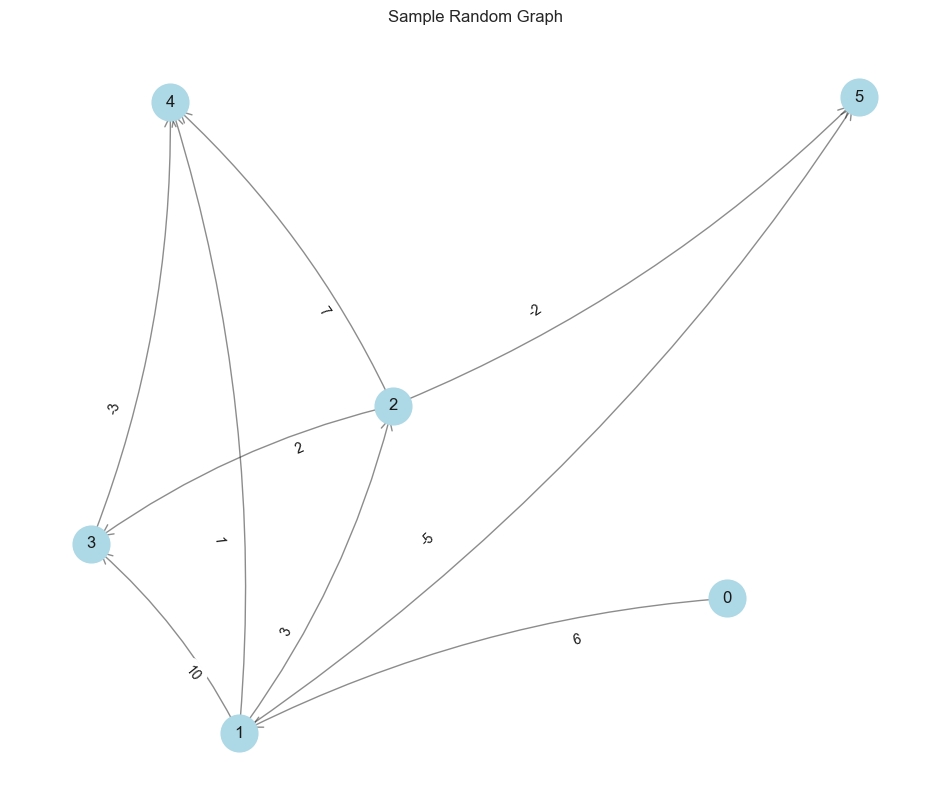

[(1, 5, -5), (1, 4, 1), (1, 3, 10), (2, 3, 2), (2, 5, -2), (3, 4, -3), (0, 1, 6), (2, 4, 7), (1, 2, 3)]


In [86]:
# Візуалізуємо граф за допмогою бібліотеки networkx та matplotlib
plt.figure(figsize=(8, 6))
demo_graph.visualize(title="Sample Random Graph")
print(demo_graph.edges)

Виводимо матрицю суміжності для нашого графа:

In [87]:
matrix = demo_graph.to_adjacency_matrix()
print("Adjacency Matrix:")
print(np.array(matrix))

Adjacency Matrix:
[[ 0.  6. inf inf inf inf]
 [inf  0.  3. 10.  1. -5.]
 [inf inf  0.  2.  7. -2.]
 [inf inf inf  0. -3. inf]
 [inf inf inf inf  0. inf]
 [inf inf inf inf inf  0.]]


Виводимо список суміжності:

In [88]:
adj_list = demo_graph.to_adjacency_list()
print("Adjacency List:")
for u, neighbors in adj_list.items():
    print(f"{u}: {neighbors}")

Adjacency List:
0: [(1, 6)]
1: [(5, -5), (4, 1), (3, 10), (2, 3)]
2: [(3, 2), (5, -2), (4, 7)]
3: [(4, -3)]
4: []
5: []


## 4. Створення класу алгоритму Белла-Форда

In [ ]:
class BellmanFordAlgo:
    # Ініціалізація алгоритму
    def __init__(self, graph):
        self.graph = graph
        self.V = graph.V

    # Реалізація алгоритму Беллмана-Форда для списку суміжності
    def bellman_ford_list(self, src):
        # Ініціалізація відстаней
        dist = [float("Inf")] * self.V
        dist[src] = 0

        # На кожній ітерації оновлюємо відстані до вершин, якщо знайдено коротший шлях.
        # Якщо на певній ітерації жодна відстань не змінилася, це означає, 
        # що оптимальні шляхи вже знайдені, і алгоритм може завершитися раніше.
        for _ in range(self.V - 1):
            changed = False
            for u in range(self.V):
                for v, w in self.graph.adj_list[u]:
                    if dist[u] != float("Inf") and dist[u] + w < dist[v]:
                        dist[v] = dist[u] + w
                        changed = True
            if not changed:
                break

        # Перевірка на від'ємні цикли шляхом перевірки на зміну відстаней на останній ітерації
        for u in range(self.V):
            for v, w in self.graph.adj_list[u]:
                if dist[u] != float("Inf") and dist[u] + w < dist[v]:
                    print("У графі знайдено цикл з від'ємною вагою")
                    return None
        
        return dist
    
    # Реалізація алгоритму Беллмана-Форда для матриці суміжності
    def bellman_ford_matrix(self, src):
        matrix = self.graph.to_adjacency_matrix()
        dist = [float("Inf")] * self.V
        dist[src] = 0
 
        # На кожній ітерації оновлюємо відстані до вершин, якщо знайдено коротший шлях.
        # Якщо на певній ітерації жодна відстань не змінилася, це означає, 
        # що оптимальні шляхи вже знайдені, і алгоритм може завершитися раніше.
        for _ in range(self.V - 1):
            changed = False
            for u in range(self.V):
                for v in range(self.V):
                    w = matrix[u][v]
                    if w != float('inf'):
                        if dist[u] != float("Inf") and dist[u] + w < dist[v]:
                            dist[v] = dist[u] + w
                            changed = True
            if not changed:
                break

        # Перевірка на від'ємні цикли шляхом перевірки на зміну відстаней на останній ітерації    
        for u in range(self.V):
            for v in range(self.V):
                w = matrix[u][v]
                if w != float('inf'):
                    if dist[u] != float("Inf") and dist[u] + w < dist[v]:
                        print("У графі знайдено цикл з від'ємною вагою")
                        return None
                        
        return dist

    def print_solution(self, dist):
        if dist is None:
            return
        print("Відстані від початкової вершини:")
        for i in range(self.V):
            print("{0}\t\t{1}".format(i, dist[i]))

## 5. Створення функції для проведення експериментів

Створення функції **run_experiment** для проведення експериментів, яка приймає на вхід список кількості вершин **n_values** та список щільності densities. Для кожної кількості вершин буде проведено експеримент для кожної щільності. Також для точності експерименту додаємо параметр **num_trials**, який визначає кількість ітерацій на кожну пару параметрів.

In [35]:
# Створюємо функцію для проведення експерименту з кількістю вершин та щільністю графу. 
# Для кращої точності зробимо 20 спроб дефолтним параметром для кожного параметру.
def run_experiment(n_values, densities, num_trials=20):
    results = []

    for n in n_values:
        for density in densities:
            list_times = []
            matrix_times = []

            for _ in range(num_trials):
                #Генеруємо рандомний граф
                g = Graph.generate_random_graph(n, density)
                bf = BellmanFordAlgo(g)

                # Вимірюємо час виконання для списку суміжності
                start = time.time()
                bf.bellman_ford_list(0)
                list_times.append(time.time() - start)

                # Вимірюємо час виконання для матриці суміжності
                start = time.time()
                bf.bellman_ford_matrix(0)
                matrix_times.append(time.time() - start)

            # Середній час виконання для обох представлень графа для кожного параметру
            avg_list_time = sum(list_times) / num_trials
            avg_matrix_time = sum(matrix_times) / num_trials

            # Додаємо результати до DataFrame для кожного параметру
            results.append({
                'Vertices': n,
                'Density': density,
                'Representation': 'Adjacency List',
                'Time': avg_list_time
            })
            results.append({
                'Vertices': n,
                'Density': density,
                'Representation': 'Adjacency Matrix',
                'Time': avg_matrix_time
            })

            print(f"Completed N={n}, Density={density}")
    # Повертаємо DataFrame з результатами
    return pd.DataFrame(results)

## 6. Задання параметрів для функції експерименту   

In [36]:
# Задаємо параметри експерименту
n_values = range(20, 201, 20)
densities = [0.1, 0.3, 0.5, 0.7, 0.9]

df = run_experiment(n_values, densities)

У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
Completed N=20, Density=0.1
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знайдено цикл з від'ємною вагою
У графі знай

## 7. Аналіз та візуалізація результатів

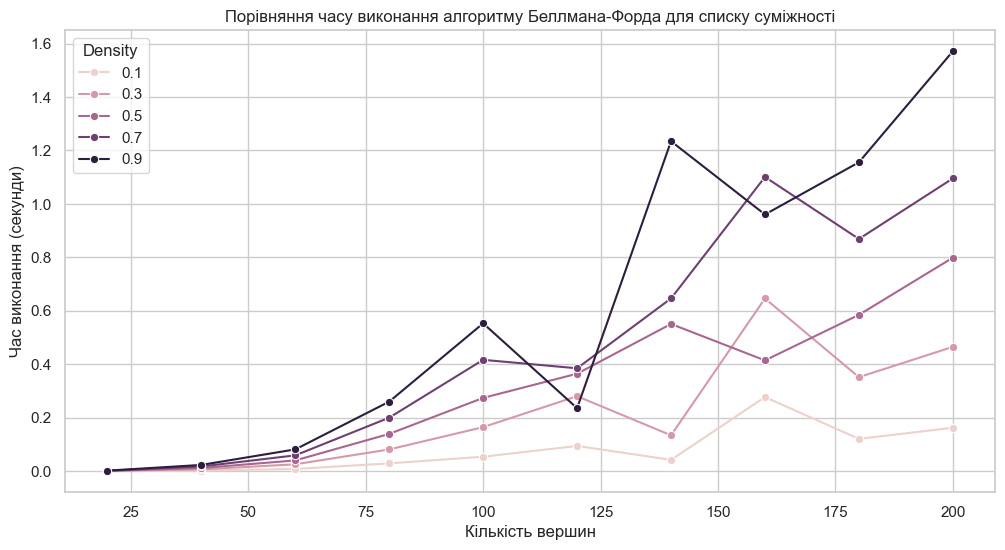

In [37]:
# За допомоиогою бібліотеки seaborn та matplotlib створюємо графік порівняння часу виконання 
# алгоритму Беллмана-Форда для списку суміжності
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[df['Representation'] == 'Adjacency List'], x='Vertices', y='Time', hue='Density', marker='o')
plt.title('Порівняння часу виконання алгоритму Беллмана-Форда для списку суміжності')
plt.ylabel('Час виконання (секунди)')
plt.xlabel('Кількість вершин')
plt.show()

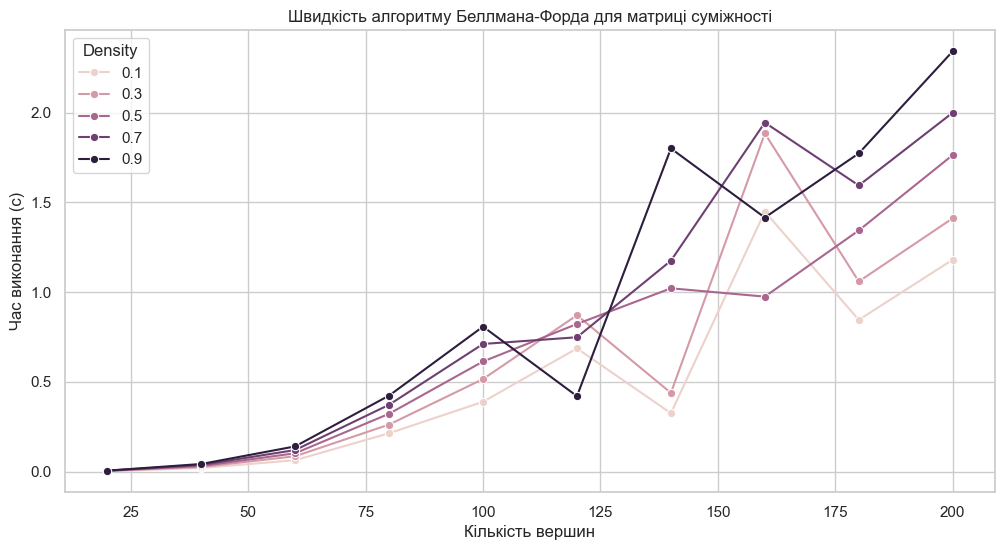

In [38]:
# За допомоиогою бібліотеки seaborn та matplotlib створюємо графік порівняння часу виконання 
# алгоритму Беллмана-Форда для матриці суміжності
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[df['Representation'] == 'Adjacency Matrix'], x='Vertices', y='Time', hue='Density', marker='o')
plt.title('Швидкість алгоритму Беллмана-Форда для матриці суміжності')
plt.ylabel('Час виконання (с)')
plt.xlabel('Кількість вершин')
plt.show()

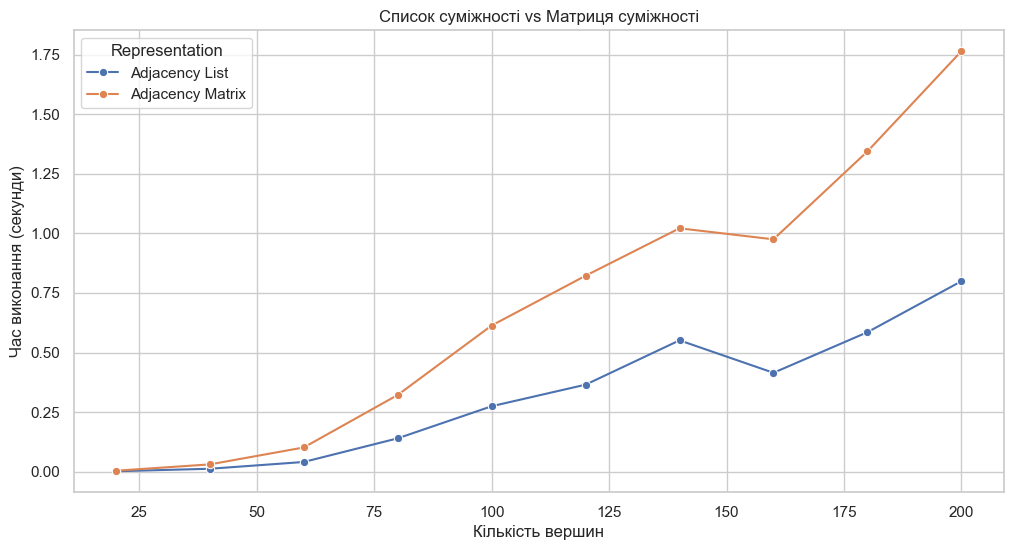

In [39]:
# Порівняння часу виконання алгоритму Беллмана-Форда для списку суміжності та матриці суміжності
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[df['Density'] == 0.5], x='Vertices', y='Time', hue='Representation', marker='o')
plt.title('Список суміжності vs Матриця суміжності')
plt.ylabel('Час виконання (секунди)')
plt.xlabel('Кількість вершин')
plt.show()

## 8. Висновок

У ході виконання експерименту було успішно реалізовано та протестовано алгоритм Беллмана-Форда для пошуку найкоротших шляхів у зваженому графі, що може містити ребра з від'ємною вагою. Експеримент продемонстрував здатність алгоритму коректно обробляти такі випадки, а також виявляти цикли з від'ємною вагою, що є його ключовою перевагою порівняно з алгоритмом Дейкстри.

Було проведено аналіз часової складності алгоритму, яка становить **O(V*E)**, де V — кількість вершин, а E — кількість ребер. Ця складність була підтверджена на практиці при роботі з різними розмірами графів. Хоча алгоритм Беллмана-Форда є менш ефективним за алгоритм Дейкстри для графів без від'ємних ваг, його універсальність робить його незамінним інструментом у задачах, де можуть зустрічатися від'ємні ваги ребер.

Також, було відзначено, що вибір структури даних для представлення графа (матриця суміжності або список суміжності) суттєво впливає на практичну продуктивність алгоритму. Для алгоритму Беллмана-Форда, який багаторазово ітерує по всіх ребрах, використання списку суміжності виявилося більш ефективним, особливо для розріджених графів, оскільки дозволяє опрацьовувати лише існуючі ребра **(O(E) операцій за ітерацію)**, на відміну від матриці суміжності, яка вимагала б перевірки всіх можливих пар вершин **(O(V^2) операцій за ітерацію)**. Цей аспект підкреслює важливість оптимального вибору структур даних для реалізації графових алгоритмів.

